# Start here!

Here I am using the open data under the SEG 2016 facies classification tutorial.

There are 9 different facies there were classified using core analysis. If we label them:

1. Nonmarine sandstone 
2. Nonmarine coarse siltstone
3. Nonmarine fine siltstone
4. Marine siltstone and shale
5. Mudstone (limestone. 
6. Wackestone (limestone. 
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

Let's import some functions we are using.

In [4]:
from os.path import join

from pandas import read_csv, options, set_option

from matplotlib.pyplot import close

from globals import FACIES_LABELS, FACIES_COLORS
from visualization import make_facies_log_plot

# Set display parameters for pandas and matplotlib
set_option("display.max_rows", 10)
options.mode.chained_assignment = None
%matplotlib inline

print("Imported all functions successfully!")

Imported all functions successfully!


Now that we have the library functions we need, we can start reading data.

For reading and organizing data, I will be using Pandas. After reading, I will show example data and statistics.

In [21]:
file_path = join('data_input', 'facies_vectors.csv')

well_data = read_csv(file_path)
well_data.set_index('Well Name', inplace=True)

well_names = well_data.index.unique()
num_wells = len(well_names)

# List names of files
print("There are %s wells in *.csv file:" % num_wells)
for well_name in well_names:
    print("  - %s" % well_name)
    
well_data

There are 10 wells in *.csv file:
  - SHRIMPLIN
  - ALEXANDER D
  - SHANKLE
  - LUKE G U
  - KIMZEY A
  - CROSS H CATTLE
  - NOLAN
  - Recruit F9
  - NEWBY
  - CHURCHMAN BIBLE


,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Well Name,,,,,,,,,,
SHRIMPLIN,3,A1 SH,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
SHRIMPLIN,3,A1 SH,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
SHRIMPLIN,3,A1 SH,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
SHRIMPLIN,3,A1 SH,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
SHRIMPLIN,3,A1 SH,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...
CHURCHMAN BIBLE,5,C LM,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
CHURCHMAN BIBLE,5,C LM,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
CHURCHMAN BIBLE,5,C LM,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669


And to show stats:

In [22]:
well_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


Now that I have access to the data, I will exclude one well for blind tests. I will also plot the well.

Rest of the wells will be used for training the model.

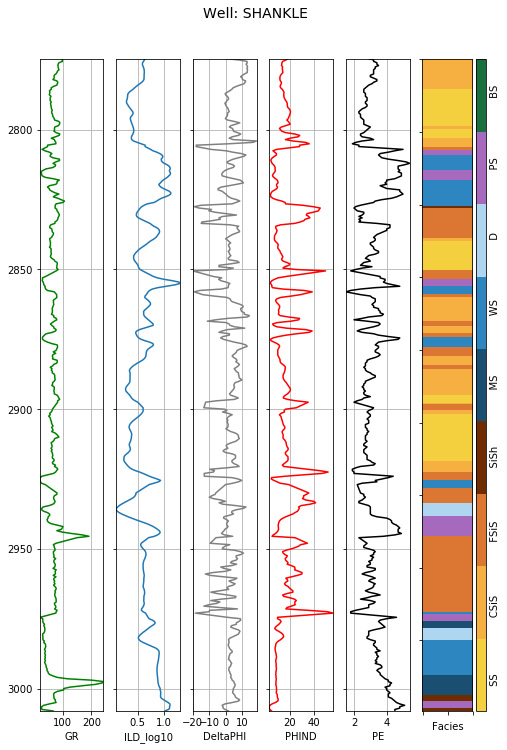

In [23]:
blind_well = well_data.loc['SHANKLE']
make_facies_log_plot(blind_well, FACIES_COLORS)
training_data = well_data.drop('SHANKLE')
training_wells = training_data.index.unique()